# Experiment : Frozen Noise Classification

In this experiment, the simulator will be used to classify two random frozen noise patterns

### Imports

In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

from typing import Optional, Tuple, Any

# Utils
import numpy as np
from tqdm import tqdm

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Jax Imports
from jax import random as rand
from jax import numpy as jnp

from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    parameter_clustering,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    dynapsim_from_config,
    DynapseSamna,
)

from rockpool.nn.modules.module import ModuleBase
from utils import FrozenNoiseDataset, plot_Ix

# - Plotting and config
import matplotlib.pyplot as plt

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


# Step 1 : Input 

In [2]:
train_data = FrozenNoiseDataset(2)
test_data = FrozenNoiseDataset(10, seed=2023)

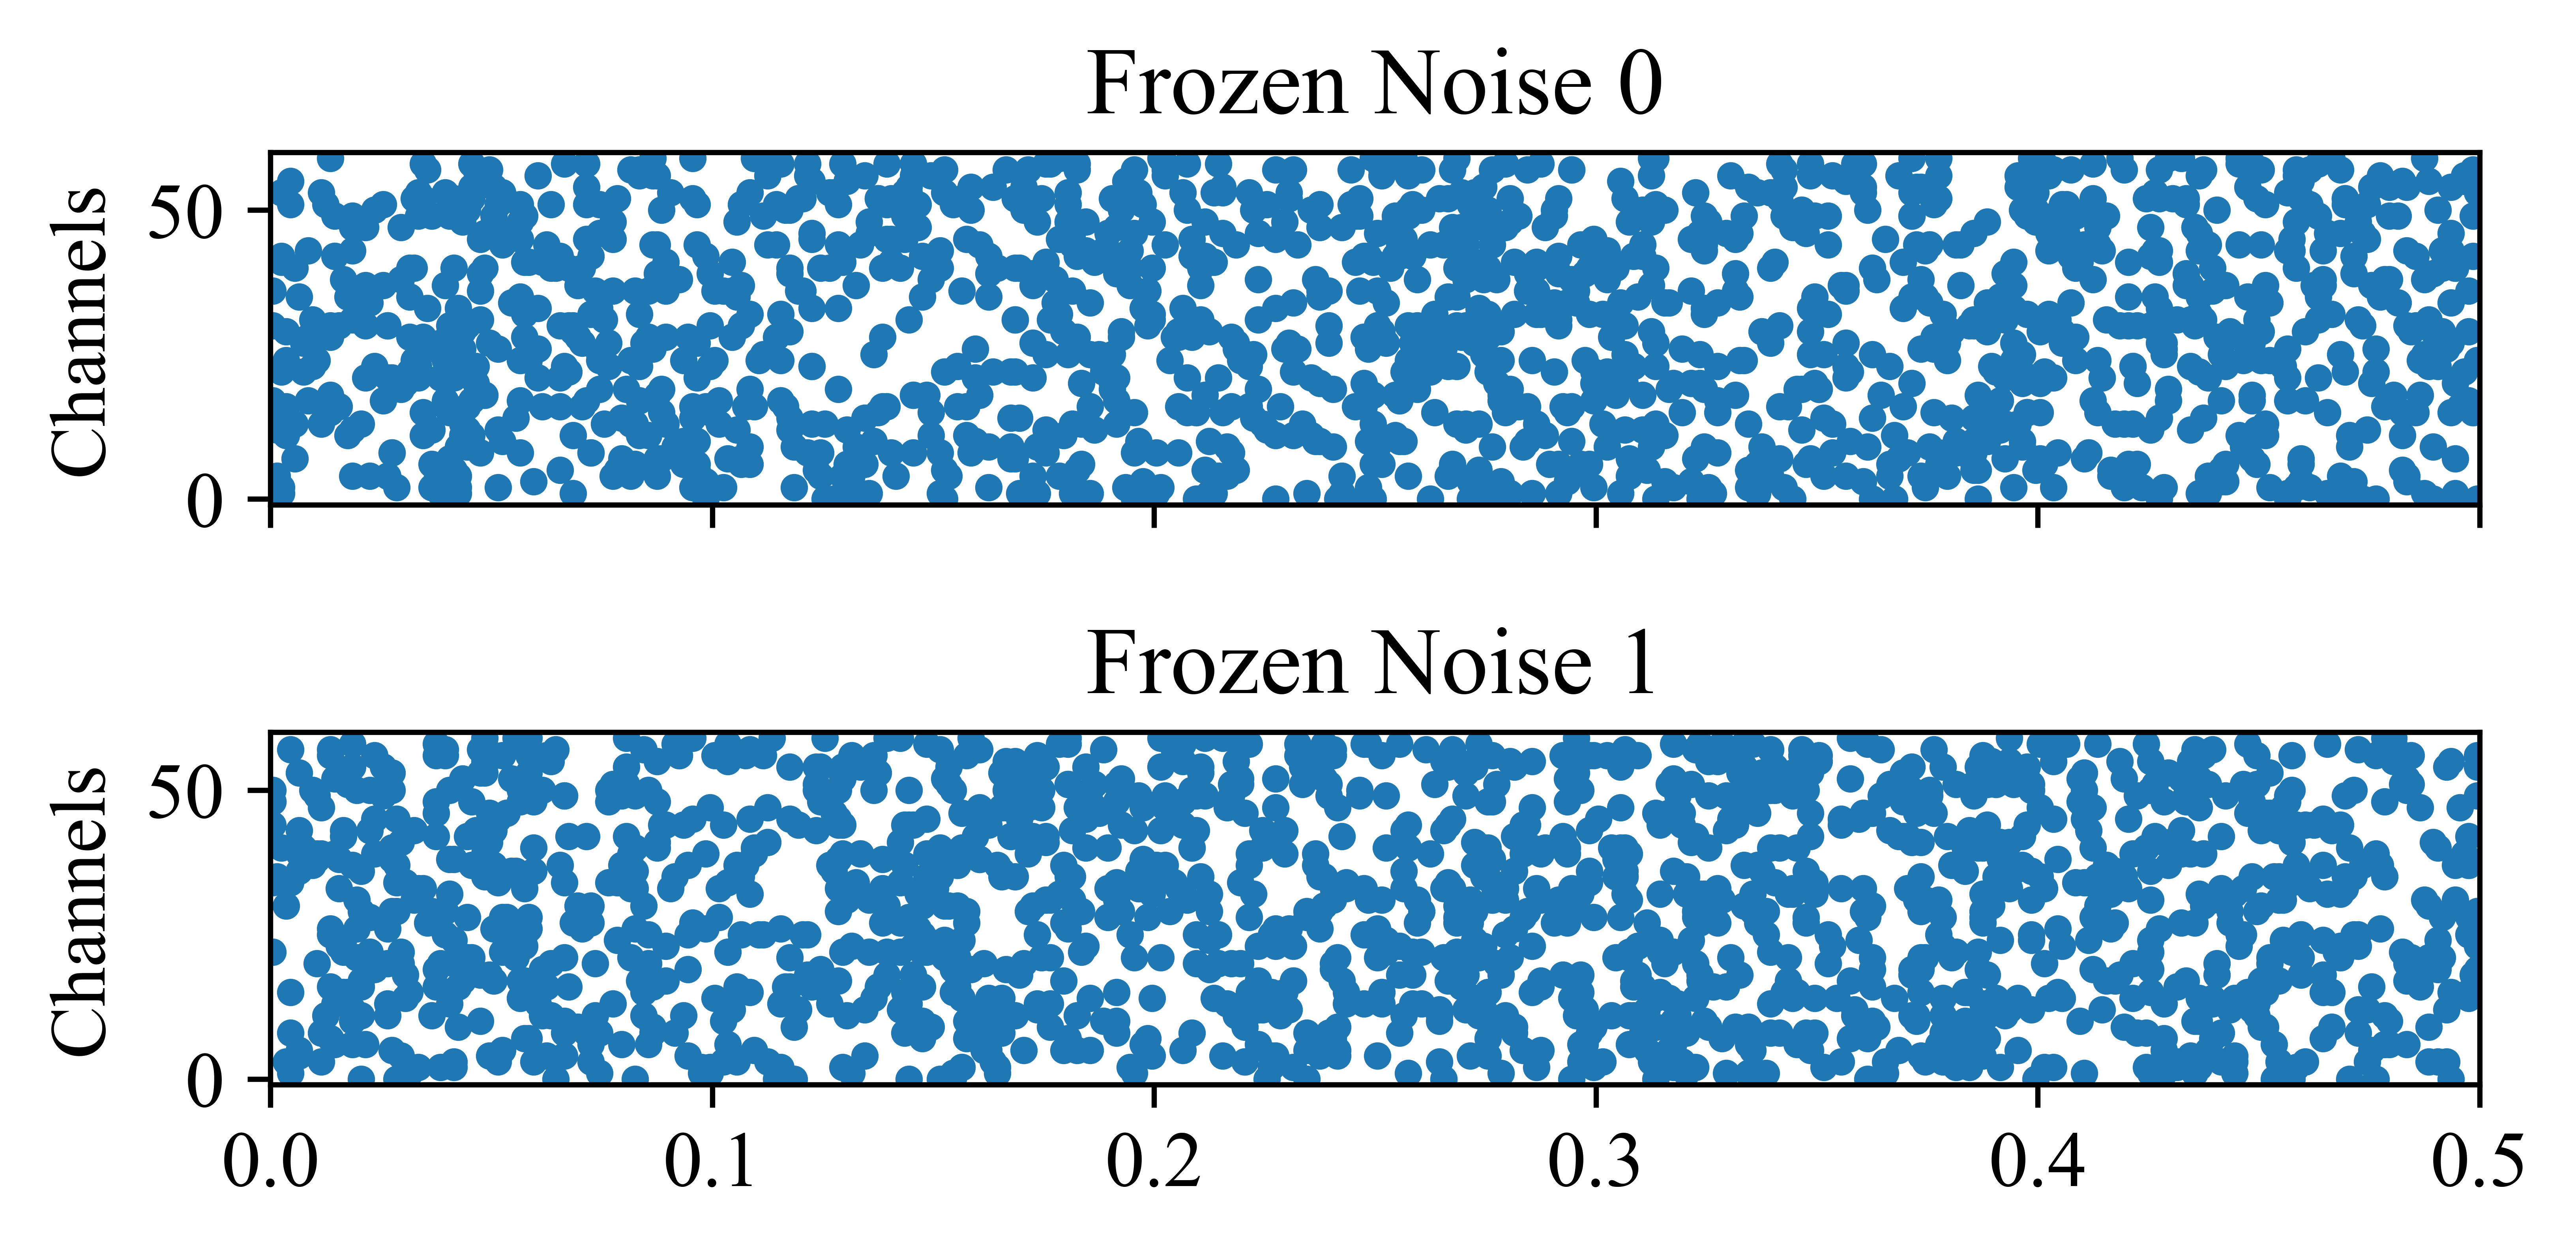

In [3]:
train_data.plot_samples(adjust_size=False)

## Step 2 : Network Configuration

Using the simulation configuration object, create a dynapse simulator

In [4]:
with open("data/w_in_optimized.npy", "rb") as f:
    w_in_optimized = np.load(f)

with open("data/w_rec_optimized.npy", "rb") as f:
    w_rec_optimized = np.load(f)

In [5]:
Nin = train_data.n_in
Nrec = train_data.n_out

In [6]:
# --- Input Layer --- #
linear_in = LinearJax(shape=(Nin, Nrec), has_bias=False, weight=w_in_optimized)
linear_in


LinearJax  with shape (60, 2)

In [7]:
# --- DynapSim Layer --- #
dynapsim = DynapSim((Nrec, Nrec), has_rec=True, w_rec = w_rec_optimized, percent_mismatch=0.05)
dynapsim

DynapSim  with shape (2, 2)

In [8]:
model = Sequential(linear_in, dynapsim)
model

JaxSequential  with shape (60, 2) {
    LinearJax '0_LinearJax' with shape (60, 2)
    DynapSim '1_DynapSim' with shape (2, 2)
}

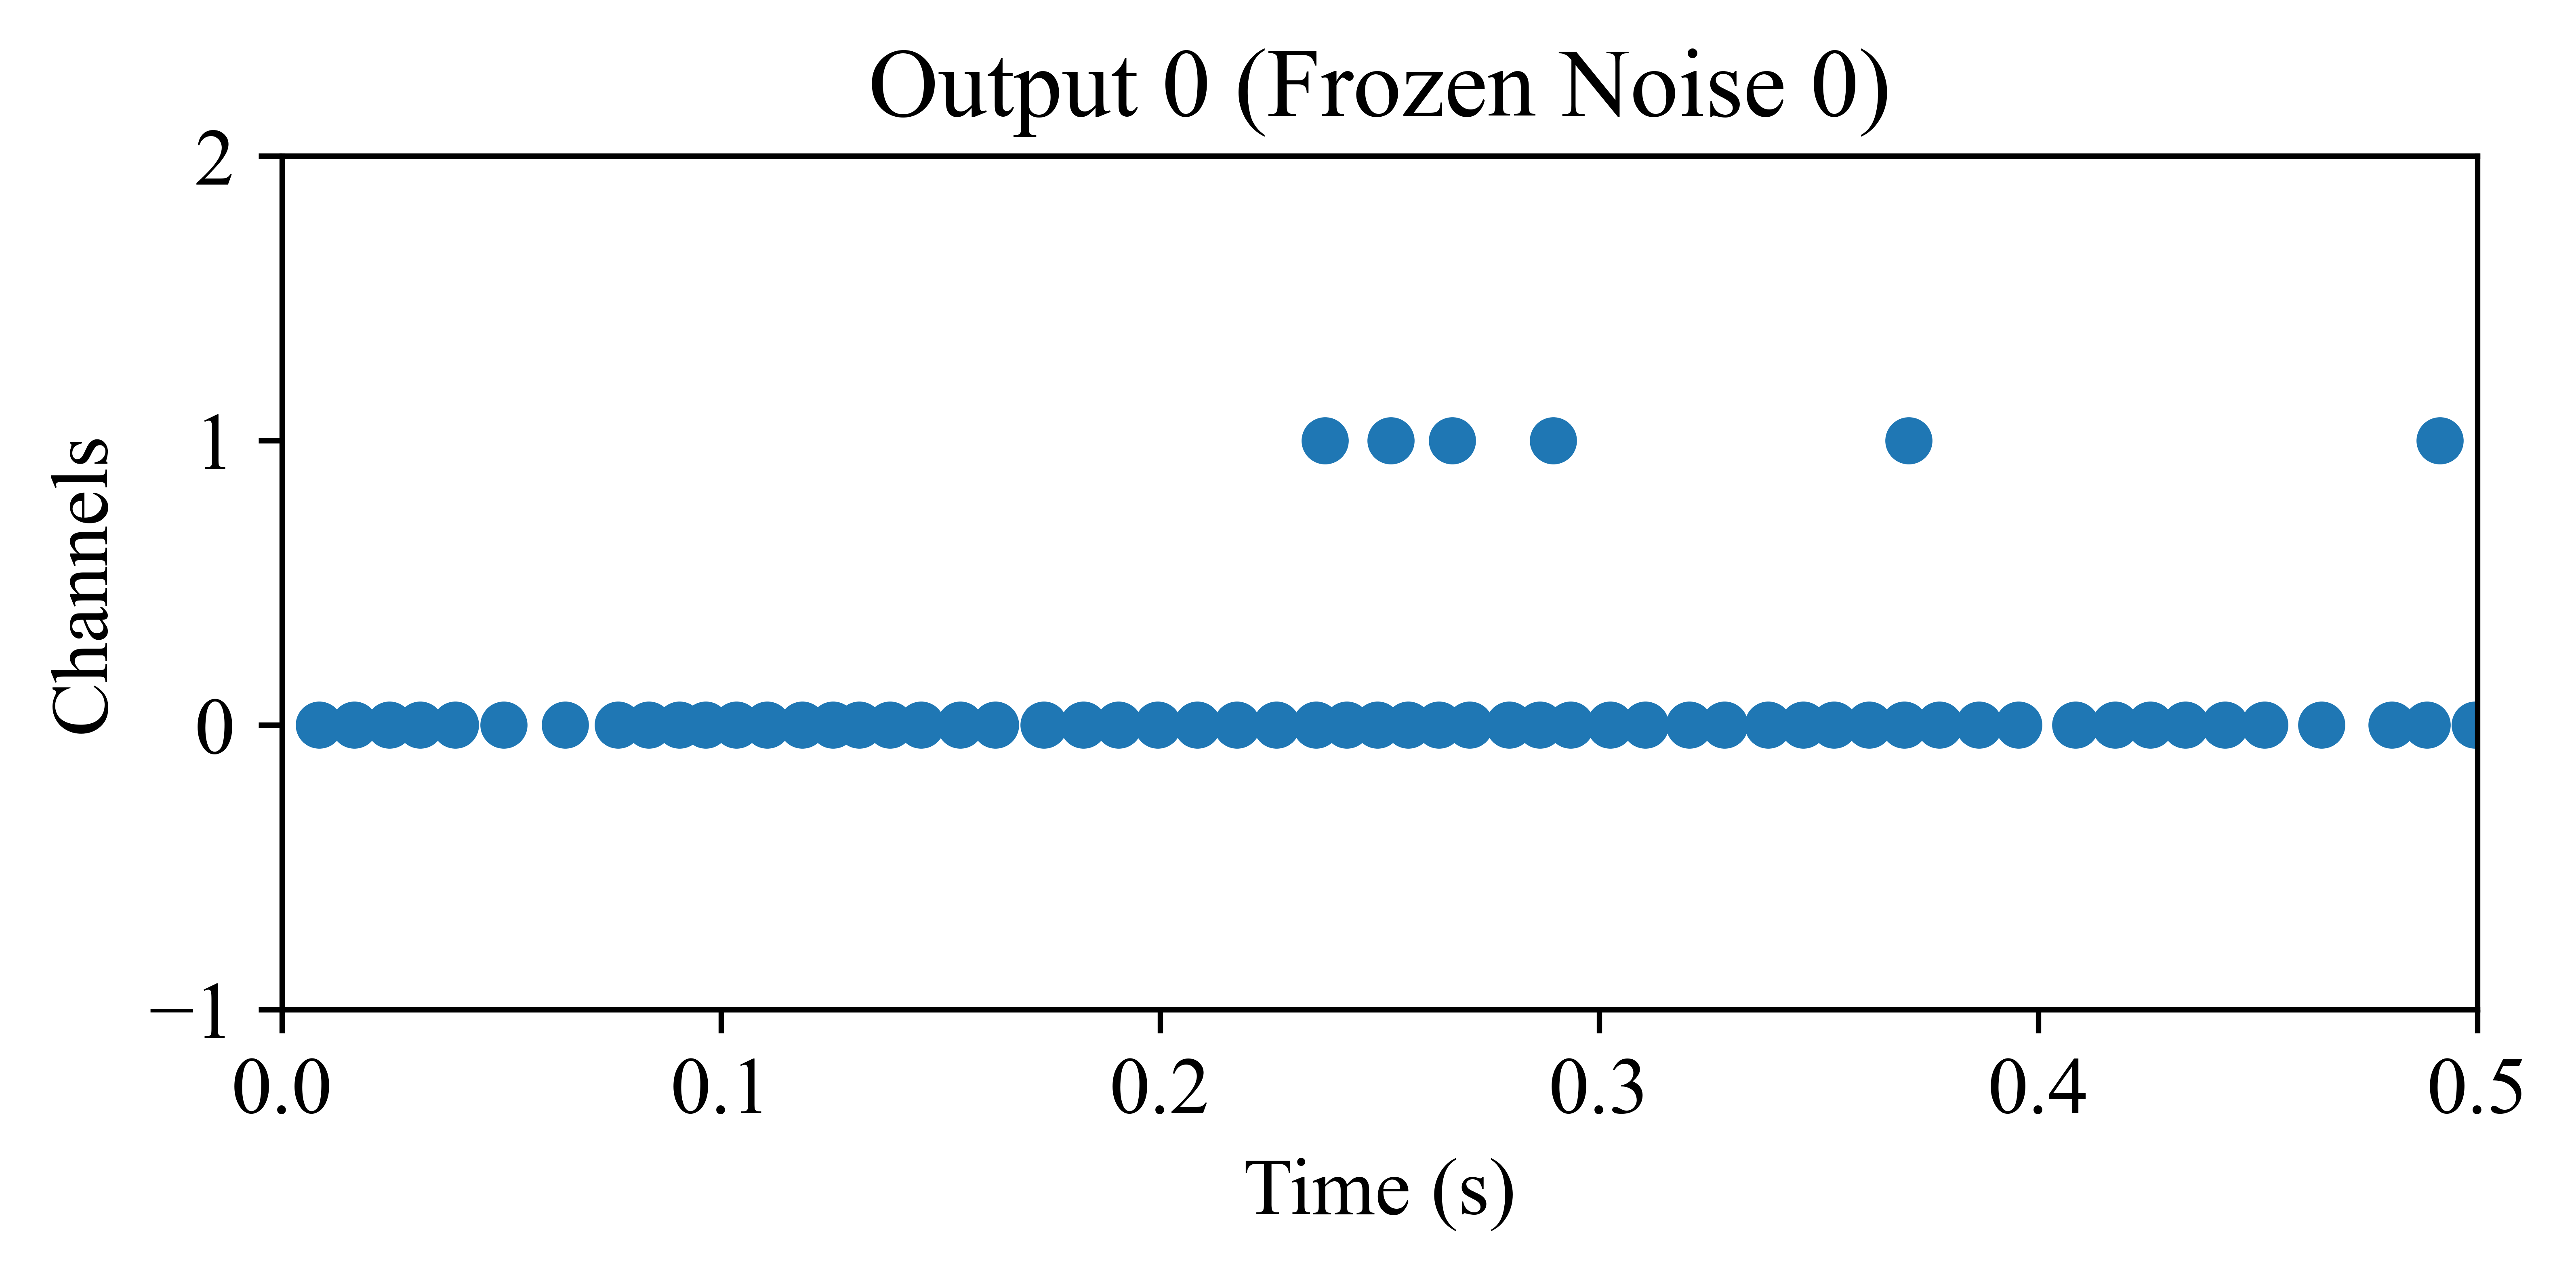

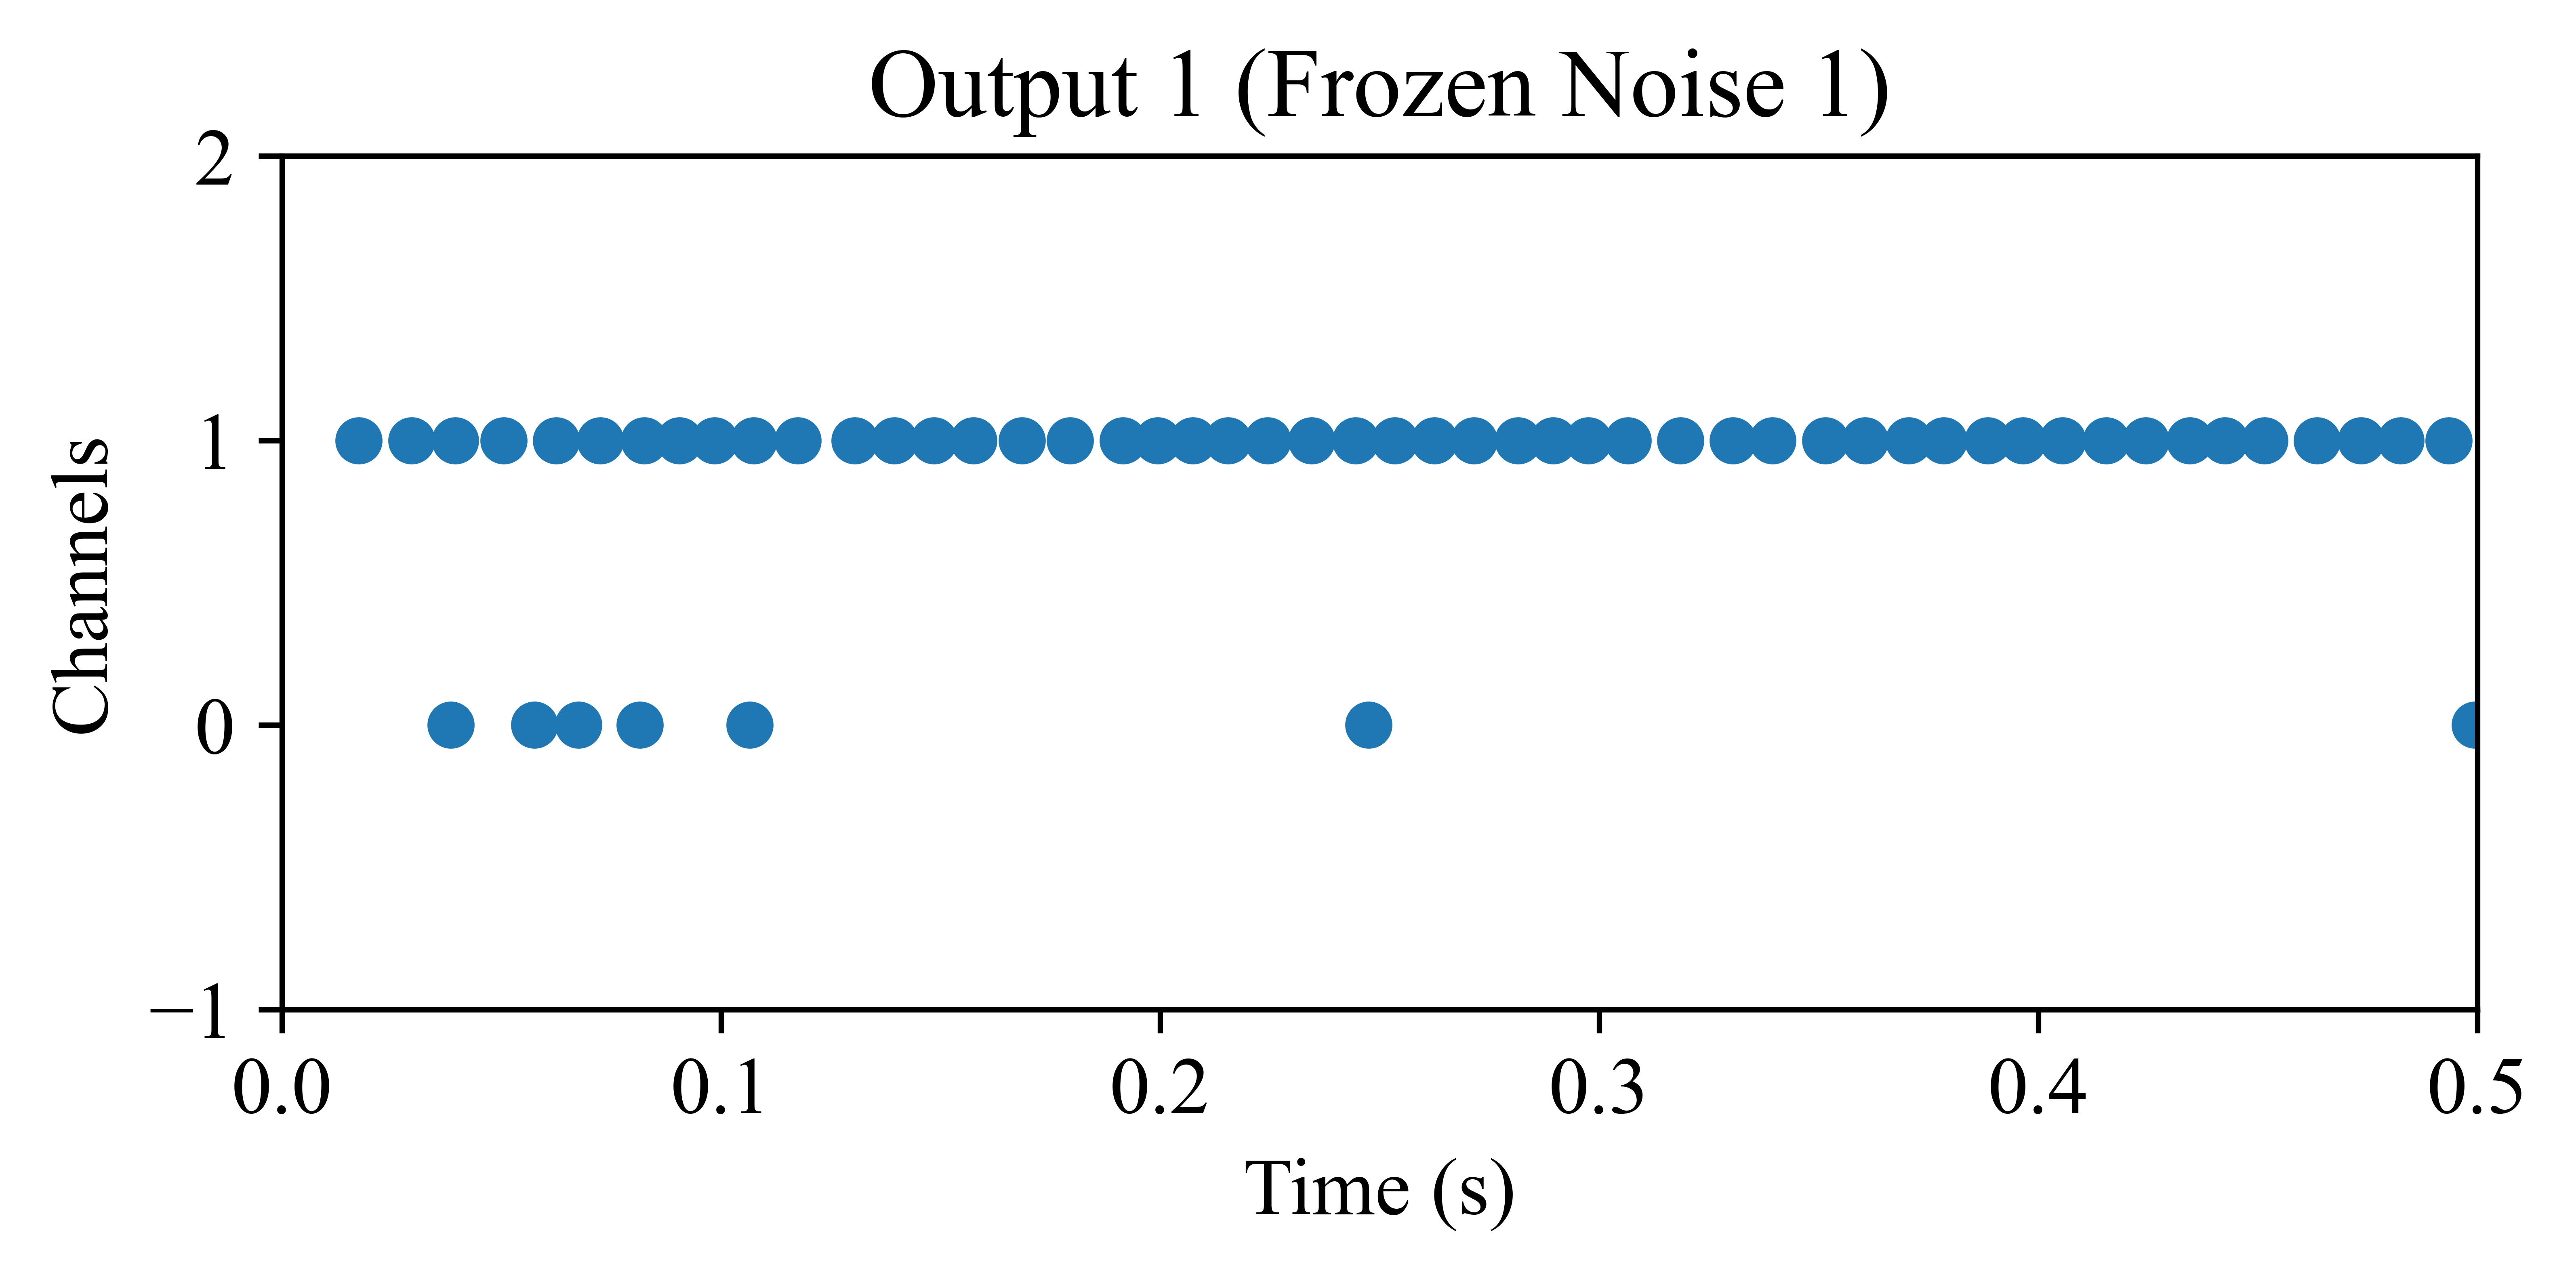

In [9]:
rec_init = []
for i in range(len(train_data)):
    plt.figure()
    inp, target = train_data[i]
    model.reset_state()
    out, _, rec = model(inp)
    rec_init.append(rec)
    output = TSEvent.from_raster(out[0], dt=1e-3, name=f"Output {i} (Frozen Noise {i})").plot()
    plt.tight_layout()

## Step 3 : Load the optimized weights

In [10]:
model.as_graph()

GraphHolder "JaxSequential__10976224416" with 60 input nodes -> 2 output nodes

In [11]:
spec = mapper(model.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__10976224416" with 60 input nodes -> 2 output nodes,
 'weights_in': array([[-4.64652729e+00, -3.11206150e+00],
        [ 5.99798298e+00, -1.15738831e+01],
        [-5.99837494e+00, -2.22357235e+01],
        [-8.32079315e+00, -3.47441888e+00],
        [ 9.89805412e+00, -1.35934260e-05],
        [-1.24091110e+01, -2.74350983e-04],
        [ 4.50127363e+00, -1.76040459e+01],
        [-1.98949516e+00, -9.62405205e+00],
        [-8.41726875e+00, -1.62834558e-03],
        [-4.80027866e+00, -4.99361897e+00],
        [-4.92892456e+00,  6.86160848e-02],
        [-3.55569410e+00,  3.11853623e+00],
        [-9.89789581e+00,  2.84956861e+00],
        [ 9.31562996e+00, -1.07101793e+01],
        [-1.61324081e+01,  5.33677929e-04],
        [-6.75756550e+00, -1.99616468e+00],
        [-1.11535320e+01, -1.53959694e+01],
        [-3.87042689e+00,  3.31276631e+00],
        [-3.50425005e+00, -4.60762930e+00],
        [ 1.55251980e+01, -4.30512047e+00],
        [

In [12]:
spec.update(parameter_clustering(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__10976224416" with 60 input nodes -> 2 output nodes,
 'weights_in': array([[-4.64652729e+00, -3.11206150e+00],
        [ 5.99798298e+00, -1.15738831e+01],
        [-5.99837494e+00, -2.22357235e+01],
        [-8.32079315e+00, -3.47441888e+00],
        [ 9.89805412e+00, -1.35934260e-05],
        [-1.24091110e+01, -2.74350983e-04],
        [ 4.50127363e+00, -1.76040459e+01],
        [-1.98949516e+00, -9.62405205e+00],
        [-8.41726875e+00, -1.62834558e-03],
        [-4.80027866e+00, -4.99361897e+00],
        [-4.92892456e+00,  6.86160848e-02],
        [-3.55569410e+00,  3.11853623e+00],
        [-9.89789581e+00,  2.84956861e+00],
        [ 9.31562996e+00, -1.07101793e+01],
        [-1.61324081e+01,  5.33677929e-04],
        [-6.75756550e+00, -1.99616468e+00],
        [-1.11535320e+01, -1.53959694e+01],
        [-3.87042689e+00,  3.31276631e+00],
        [-3.50425005e+00, -4.60762930e+00],
        [ 1.55251980e+01, -4.30512047e+00],
        [

In [13]:
spec.update(autoencoder_quantization(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__10976224416" with 60 input nodes -> 2 output nodes,
 'weights_in': [array([[ 1,  4],
         [ 4, 12],
         [ 4, 15],
         [ 1,  0],
         [ 5,  0],
         [11,  0],
         [ 4, 11],
         [ 4,  1],
         [10,  0],
         [ 1,  8],
         [ 4,  0],
         [ 1,  4],
         [12,  0],
         [ 9, 12],
         [ 7,  0],
         [ 9,  4],
         [11, 11],
         [ 4,  2],
         [ 0,  1],
         [11,  1],
         [ 0,  0],
         [ 0,  5],
         [ 7, 15],
         [ 0, 11],
         [ 7, 12],
         [14,  4],
         [ 4, 11],
         [ 9,  0],
         [ 2,  4],
         [ 0, 14],
         [ 4,  0],
         [ 0,  2],
         [ 0, 11],
         [11, 15],
         [ 0,  2],
         [ 7,  8],
         [ 5,  4],
         [10,  0],
         [11,  1],
         [15, 12],
         [ 0,  0],
         [ 4, 10],
         [ 9,  1],
         [ 0,  0],
         [ 5,  0],
         [ 0,  0],
         [ 6,  

In [14]:
spec.update(config_from_specification(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__10976224416" with 60 input nodes -> 2 output nodes,
 'weights_in': [array([[ 1,  4],
         [ 4, 12],
         [ 4, 15],
         [ 1,  0],
         [ 5,  0],
         [11,  0],
         [ 4, 11],
         [ 4,  1],
         [10,  0],
         [ 1,  8],
         [ 4,  0],
         [ 1,  4],
         [12,  0],
         [ 9, 12],
         [ 7,  0],
         [ 9,  4],
         [11, 11],
         [ 4,  2],
         [ 0,  1],
         [11,  1],
         [ 0,  0],
         [ 0,  5],
         [ 7, 15],
         [ 0, 11],
         [ 7, 12],
         [14,  4],
         [ 4, 11],
         [ 9,  0],
         [ 2,  4],
         [ 0, 14],
         [ 4,  0],
         [ 0,  2],
         [ 0, 11],
         [11, 15],
         [ 0,  2],
         [ 7,  8],
         [ 5,  4],
         [10,  0],
         [11,  1],
         [15, 12],
         [ 0,  0],
         [ 4, 10],
         [ 9,  1],
         [ 0,  0],
         [ 5,  0],
         [ 0,  0],
         [ 6,  

In [15]:
model_quantized = dynapsim_from_config(spec["config"])

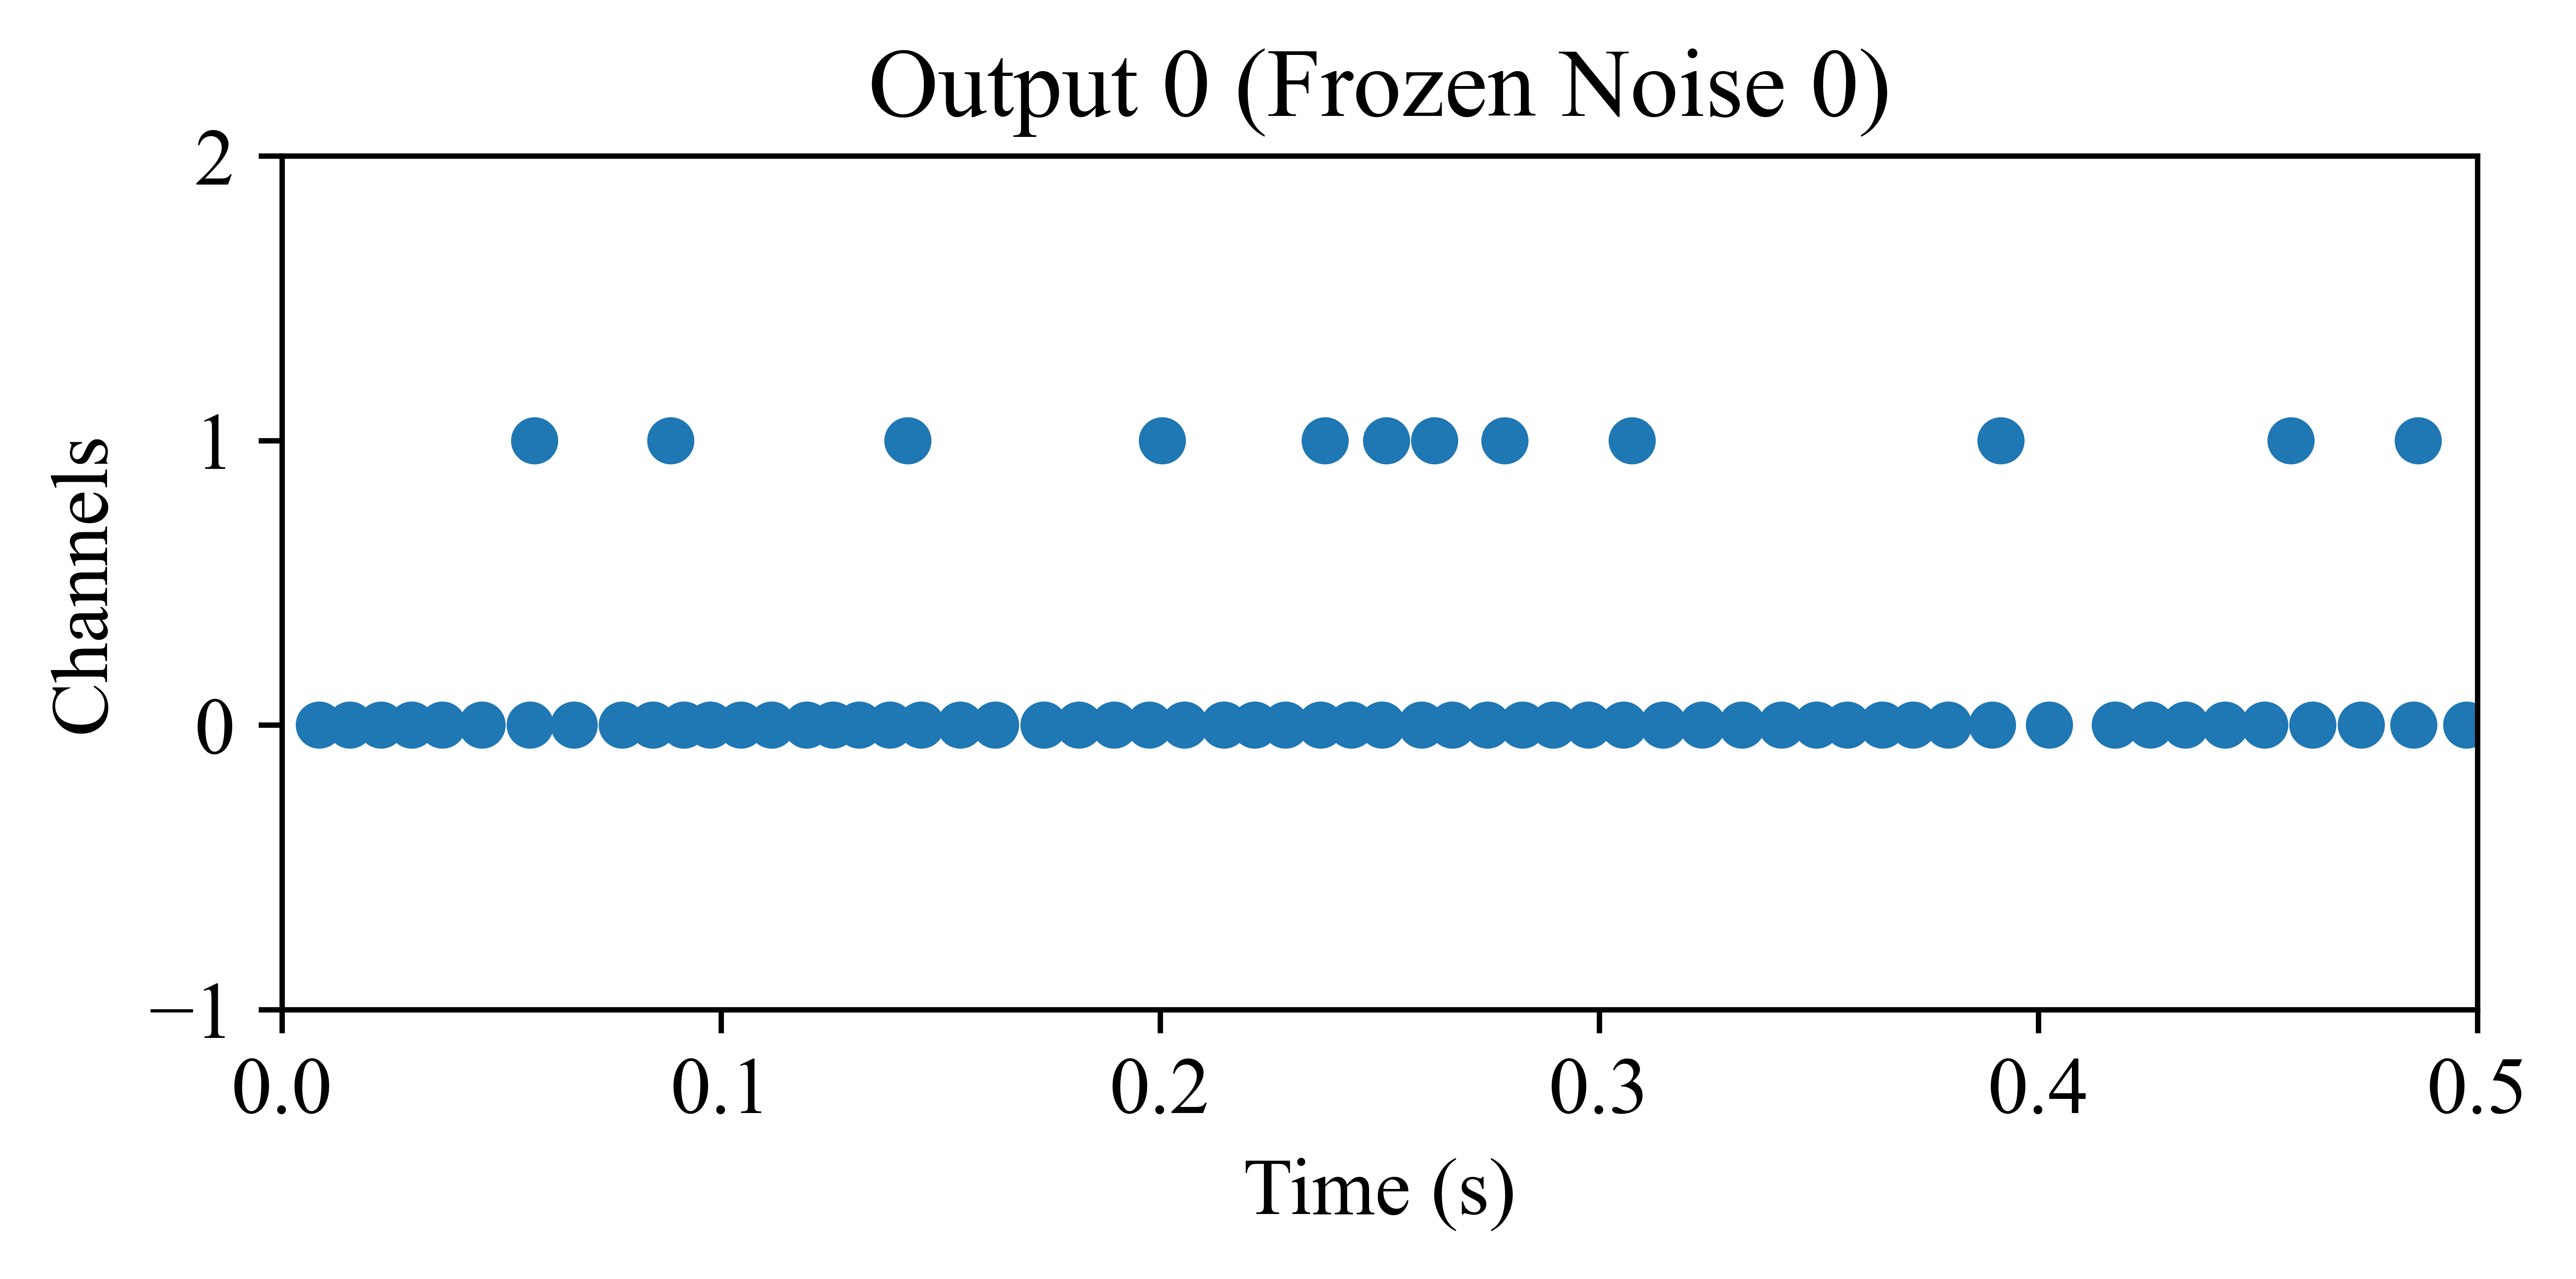

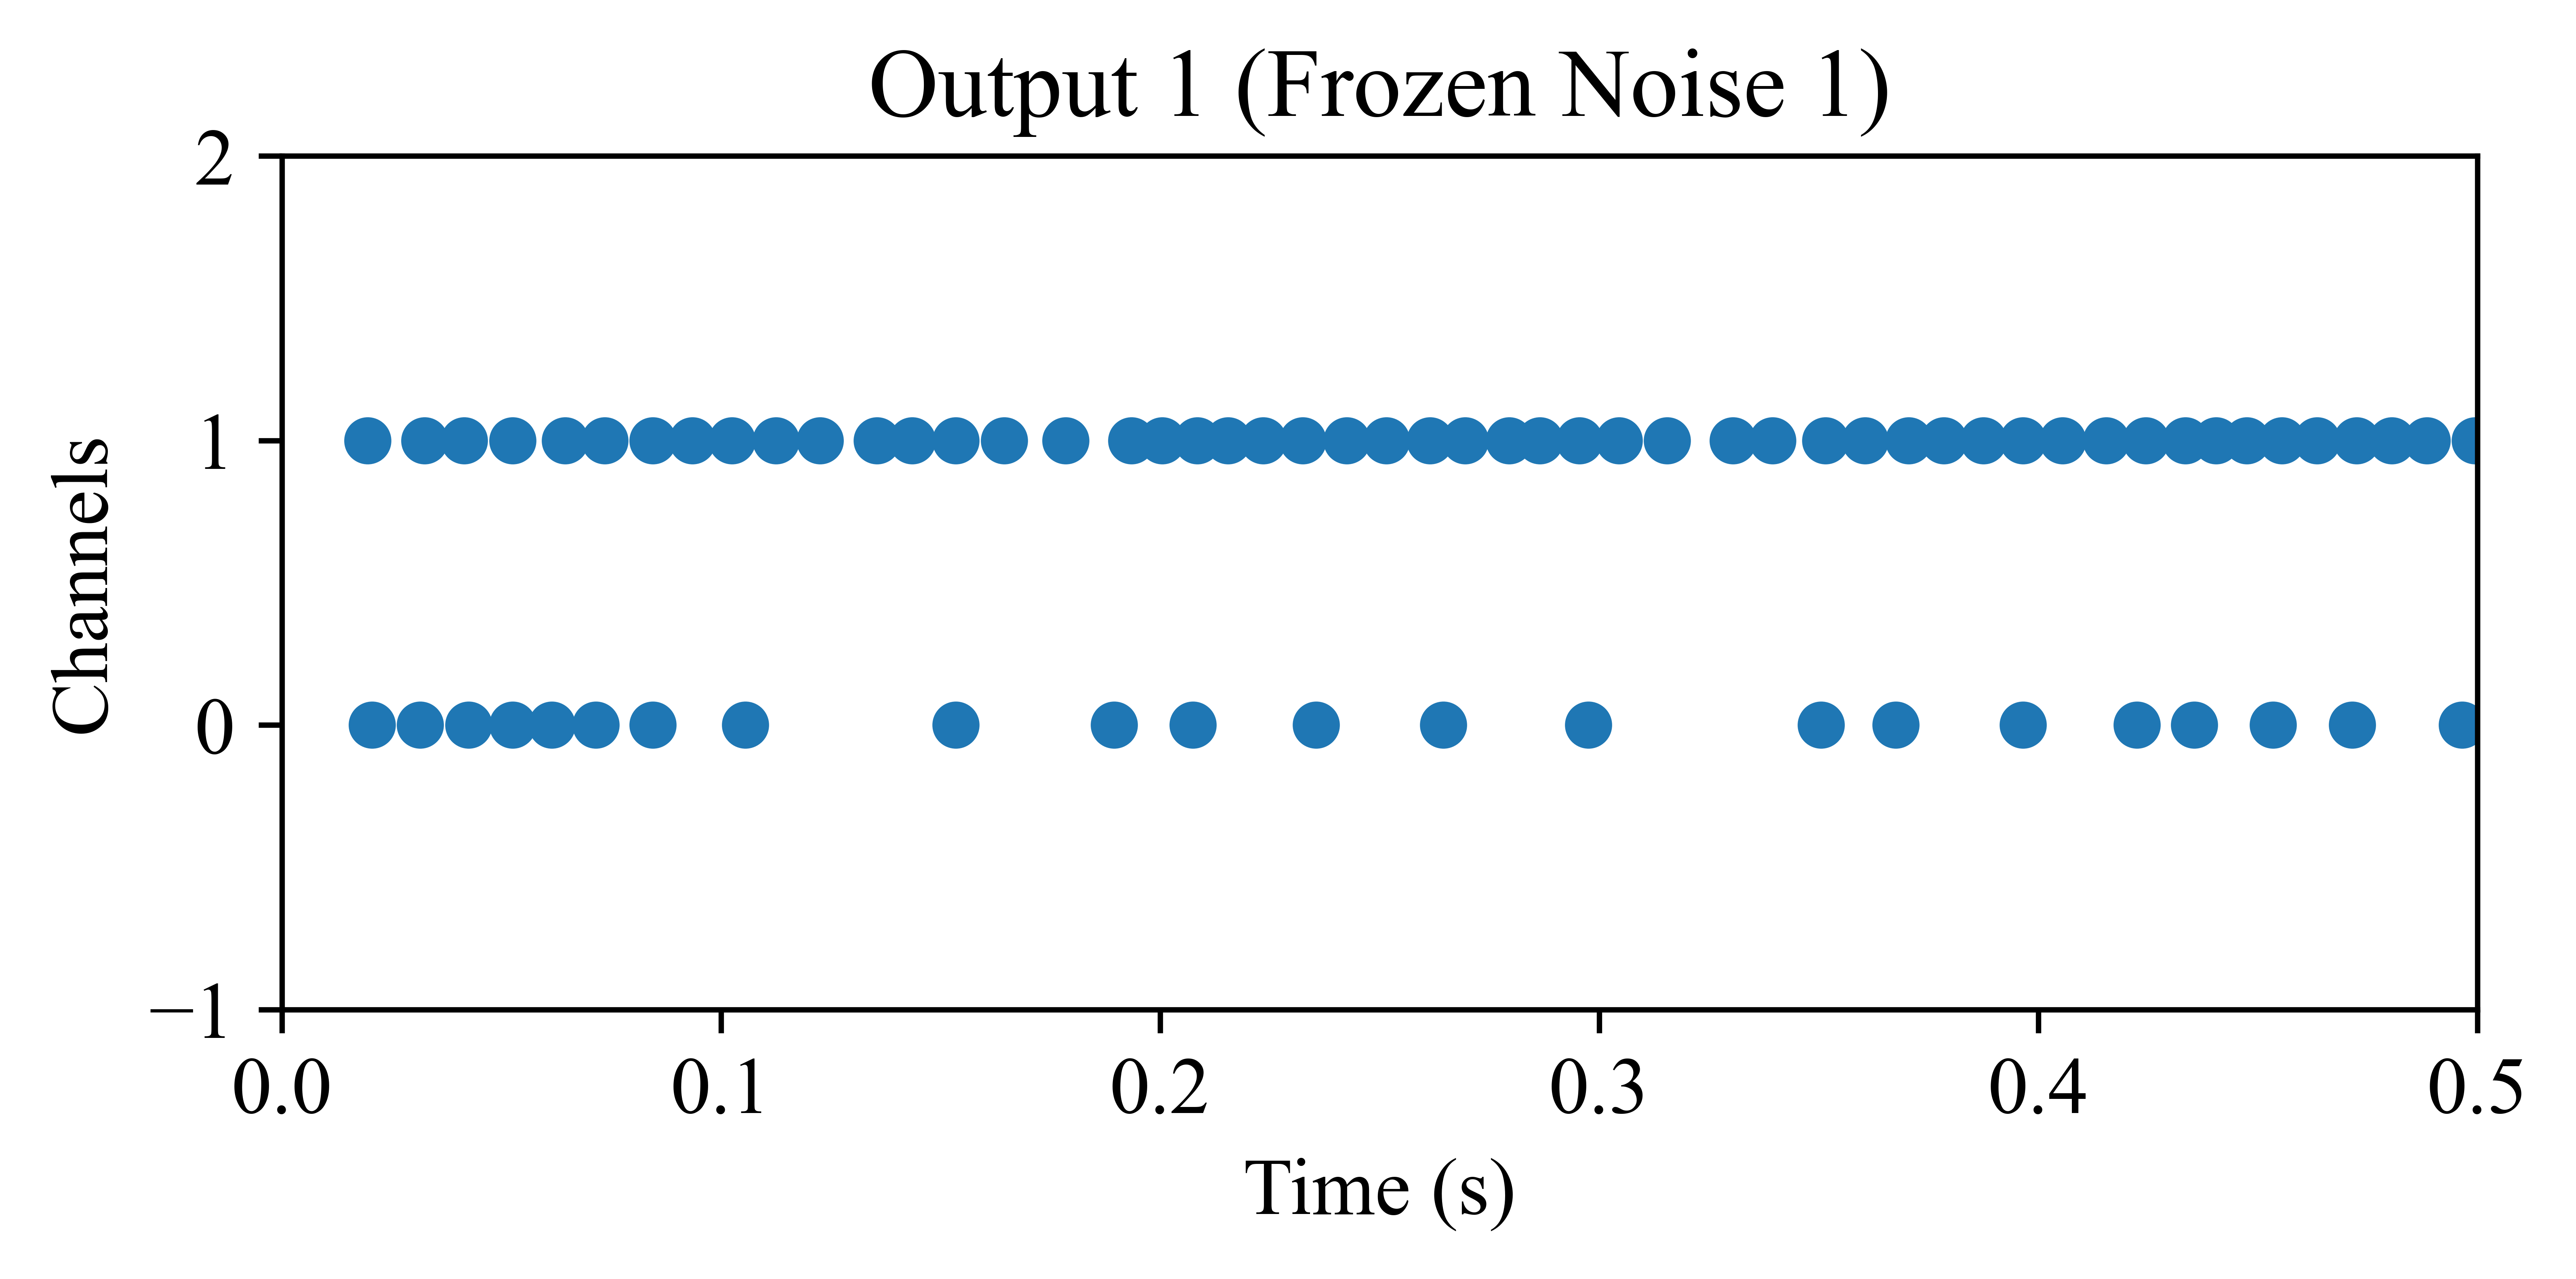

In [16]:
rec_init = []
for i in range(len(train_data)):
    plt.figure()
    inp, target = train_data[i]
    model_quantized.reset_state()
    out, _, rec = model_quantized(inp)
    rec_init.append(rec)
    output = TSEvent.from_raster(out[0], dt=1e-3, name=f"Output {i} (Frozen Noise {i})").plot()
    plt.tight_layout()

In [17]:
## Connect to device
se2_devices = find_dynapse_boards()

found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    se2 = DynapseSamna((60,2),se2_devices[0], spec["config"])

In [18]:
se2.current_timestamp()

0.317461

In [19]:
def test_network(se2, spec, instance):

    sample, label = instance
    out, state, rec = se2(sample, spec['input_channel_map'])

    fig, axes = plt.subplots(2, 1)
    ticks = list(rec["channel_map"].keys())
    labels = [dest.tag for dest in rec["channel_map"].values()]

    plt.sca(axes[0])
    TSEvent.from_raster(
        sample, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot()
    plt.xlabel("")

    plt.sca(axes[1])
    TSEvent.from_raster(
        out, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot(color="firebrick")
    plt.title("Device Output")
    plt.yticks(ticks, labels)
    plt.tight_layout()
    print(f"Rate = {np.sum(out)}")

Rate = 8.0


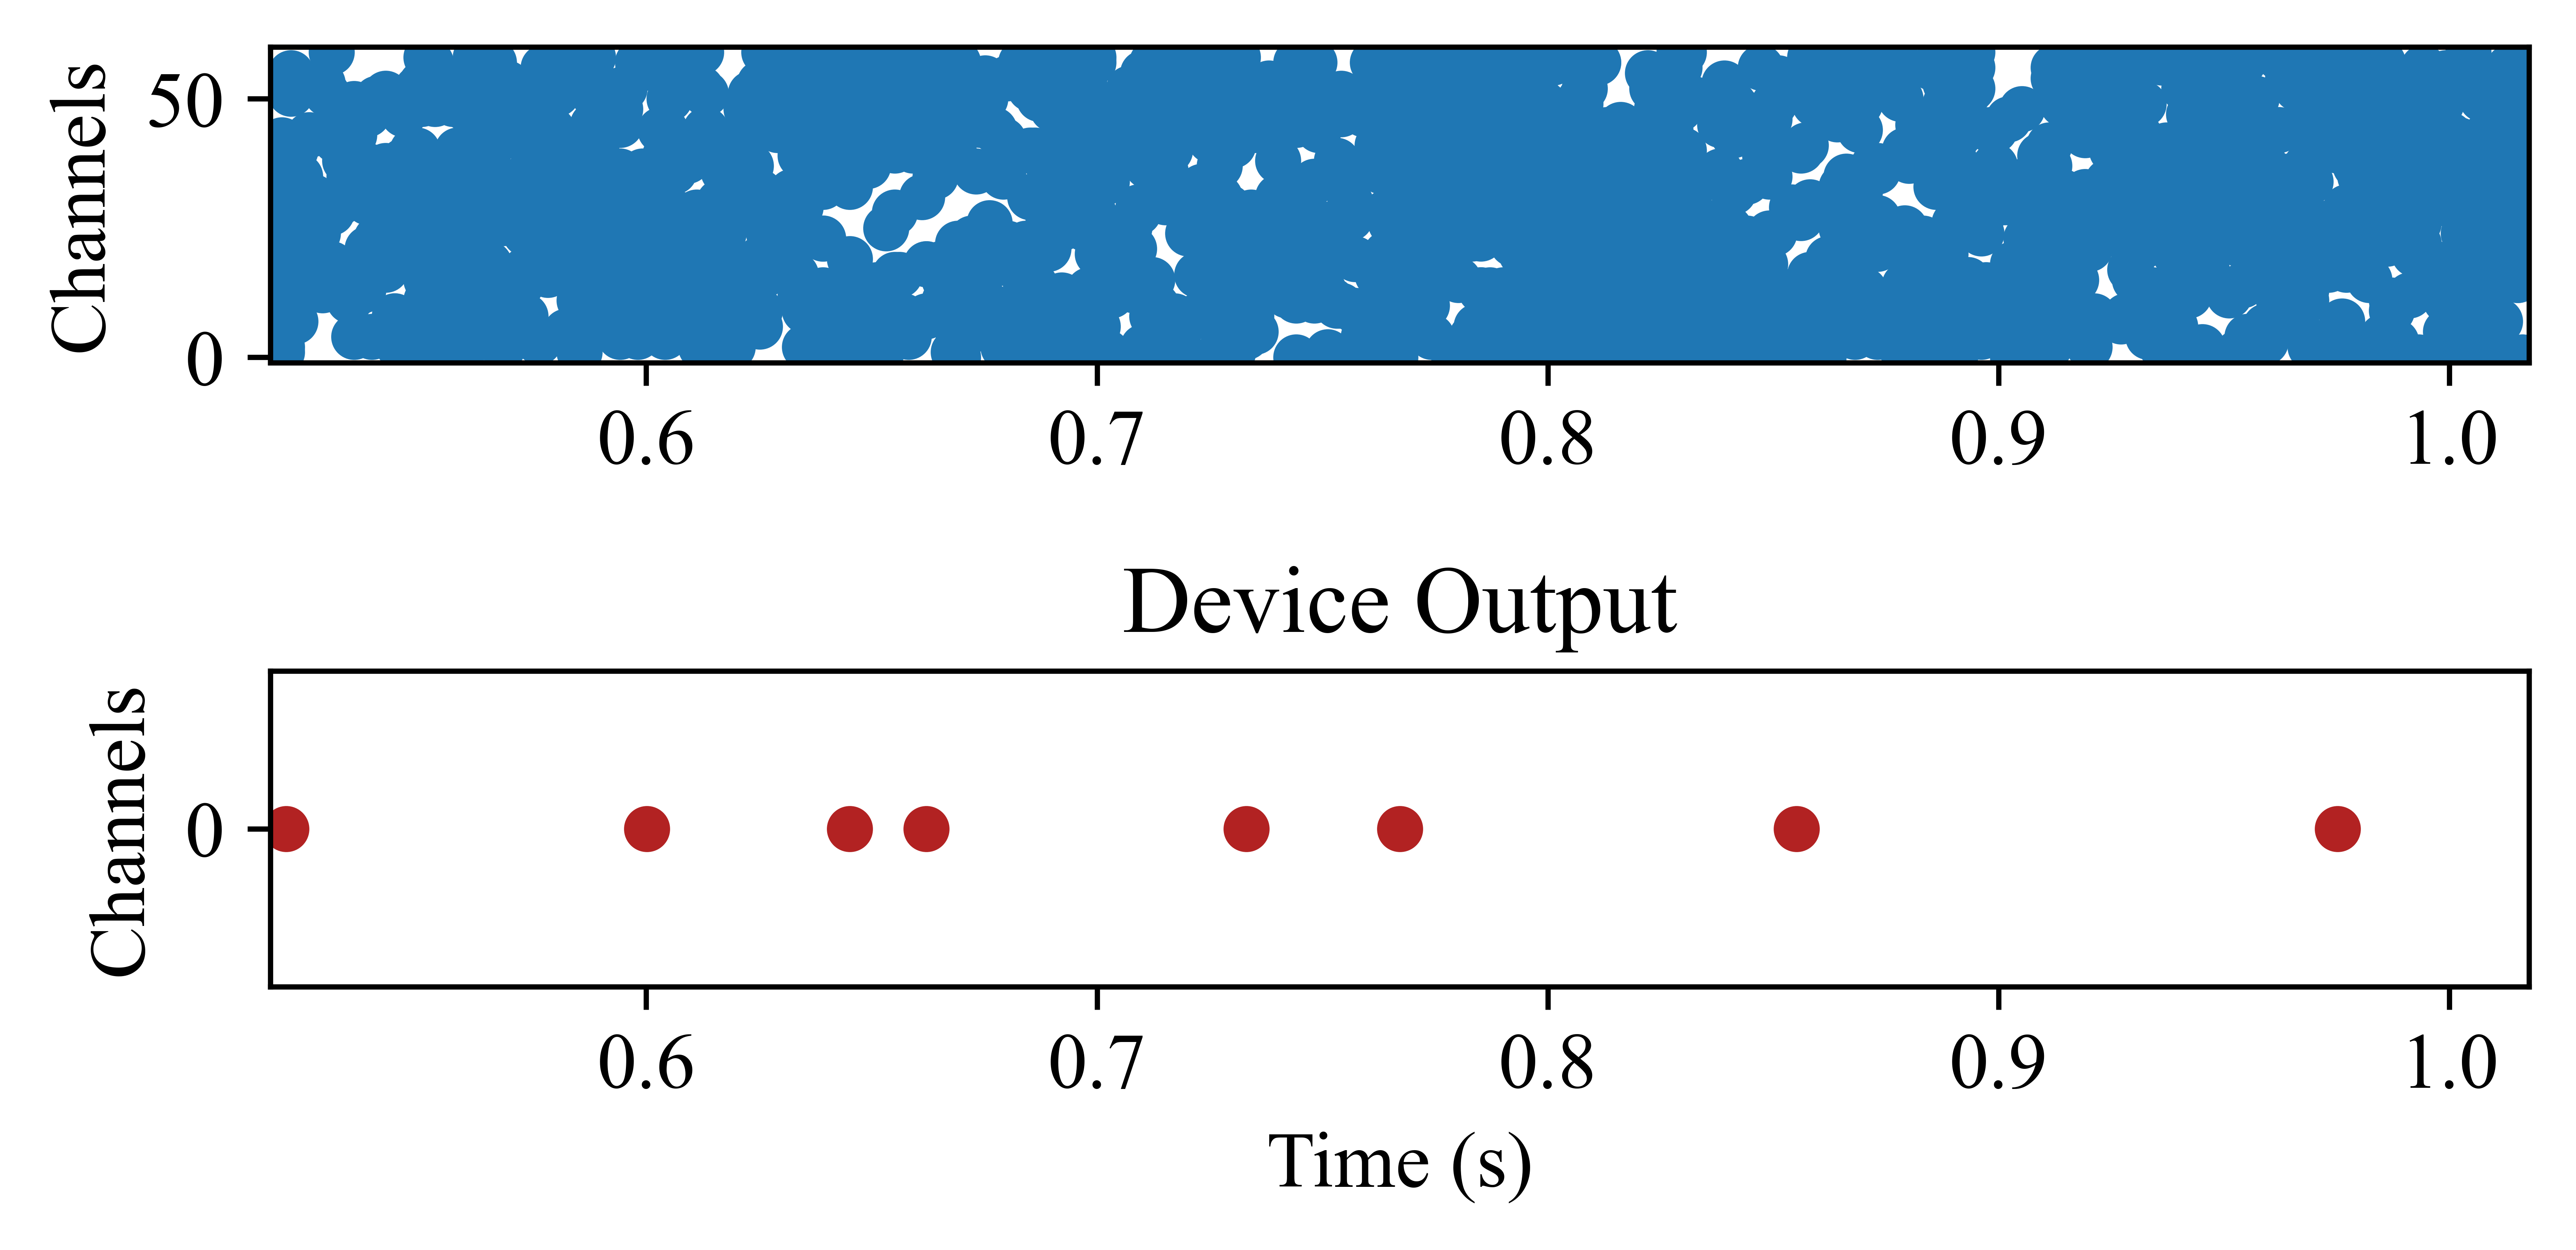

In [20]:
test_network(se2, spec, train_data[0])

Rate = 6.0


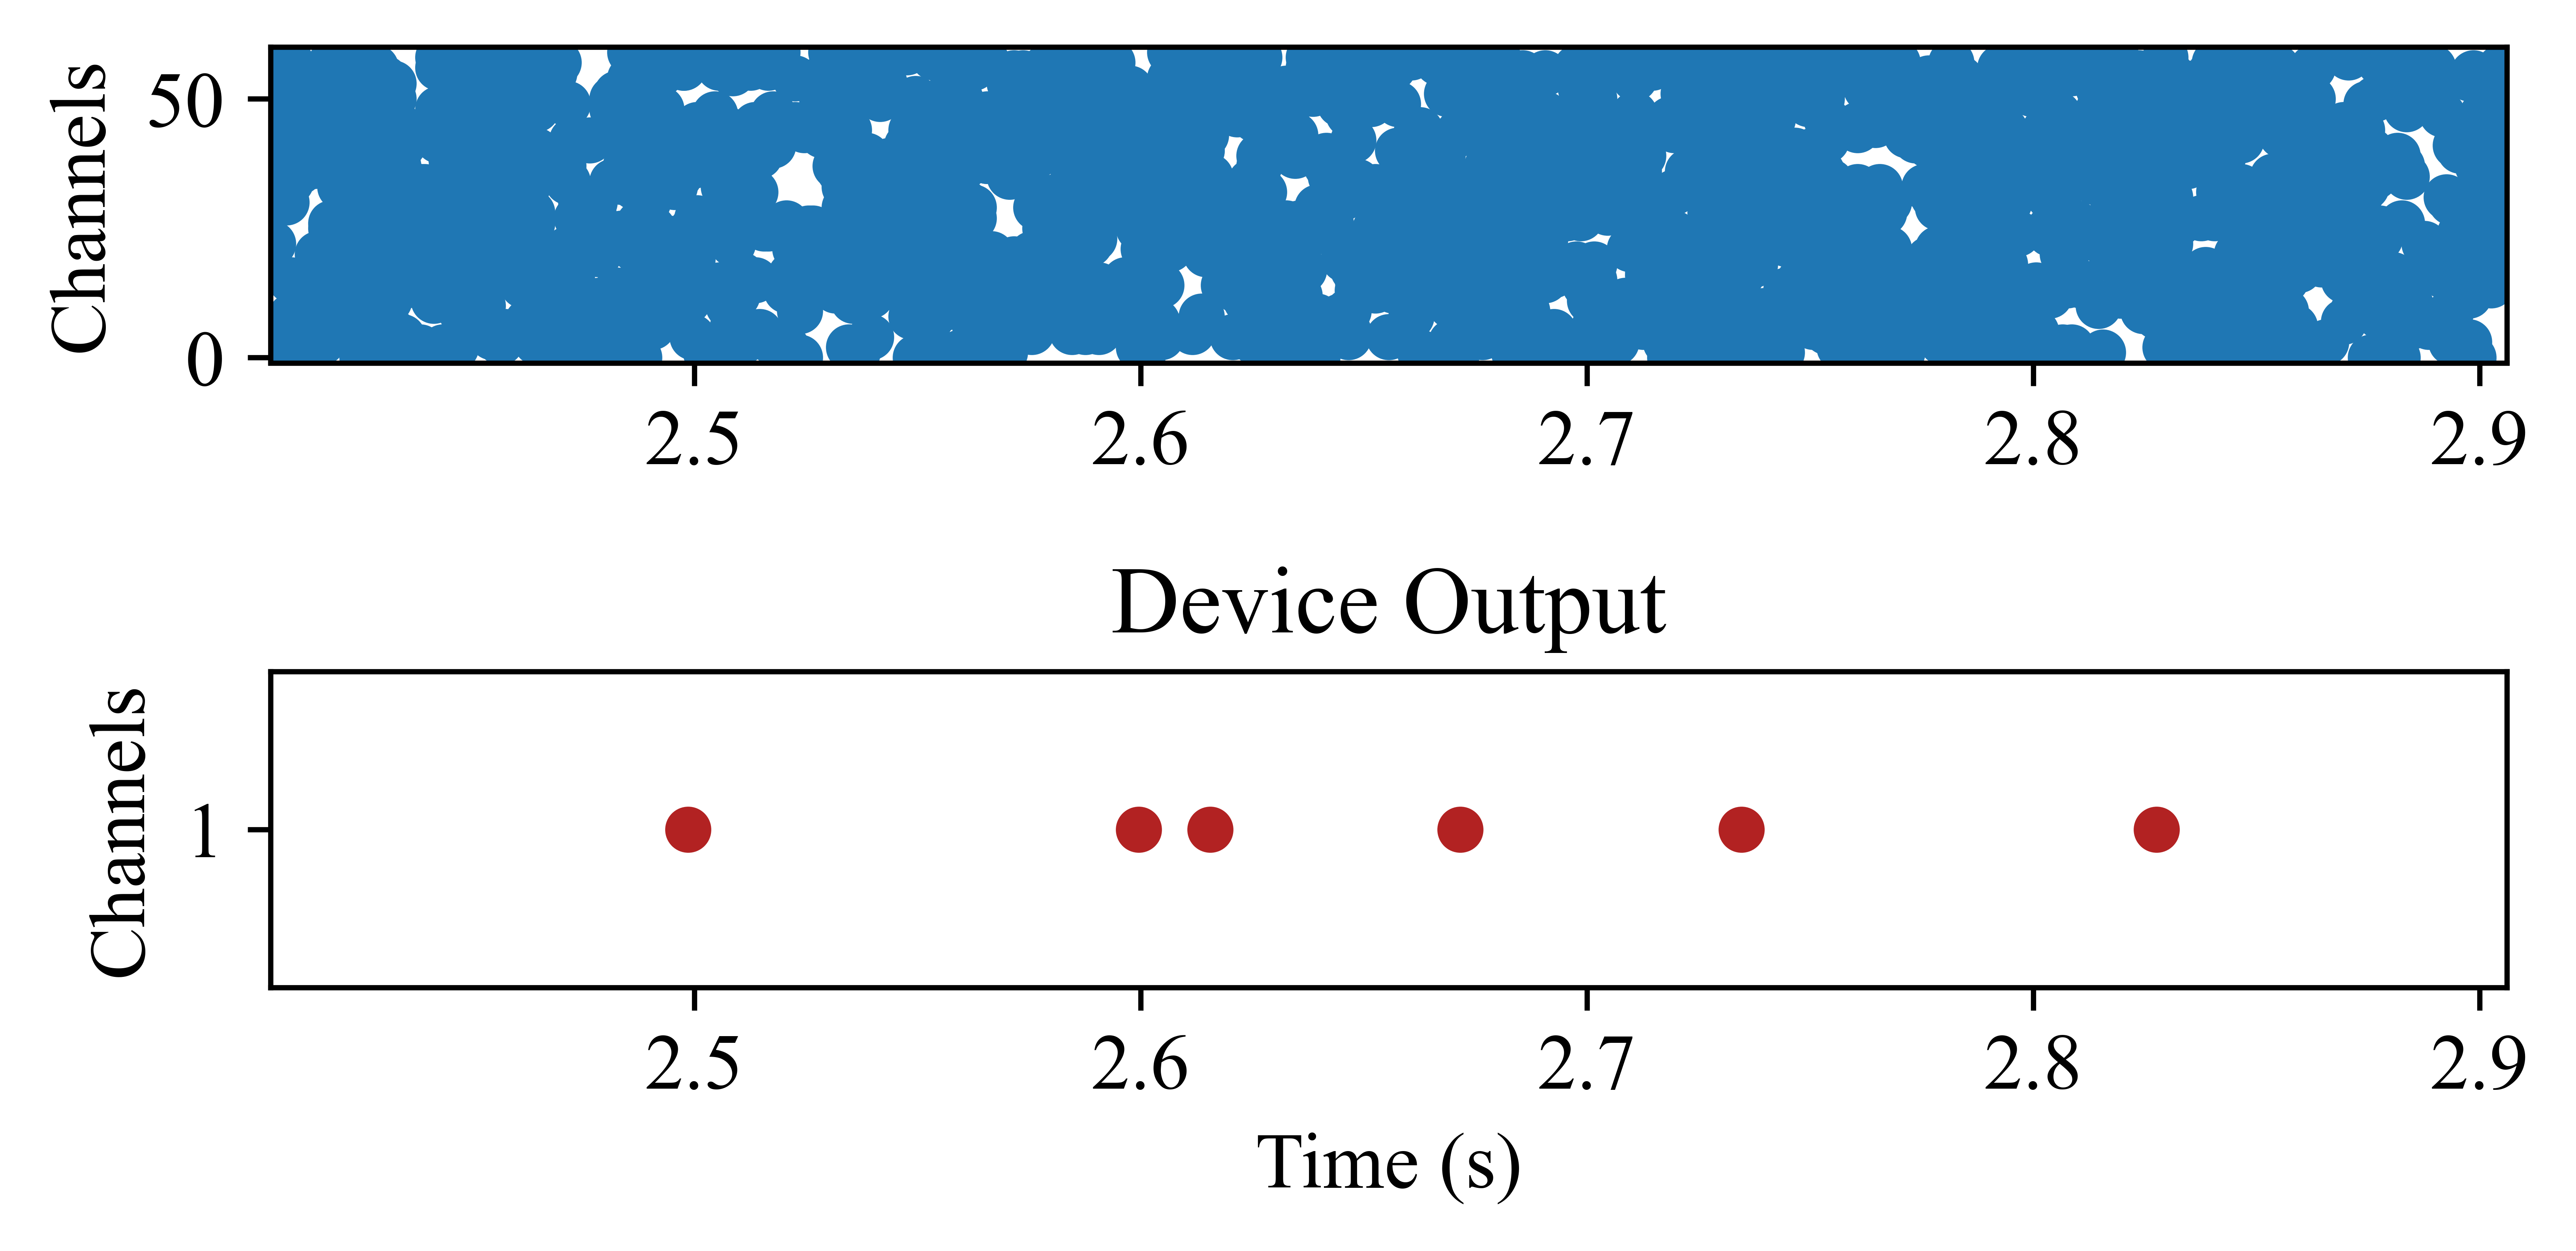

In [21]:
test_network(se2, spec, train_data[1])

Rate = 4.0


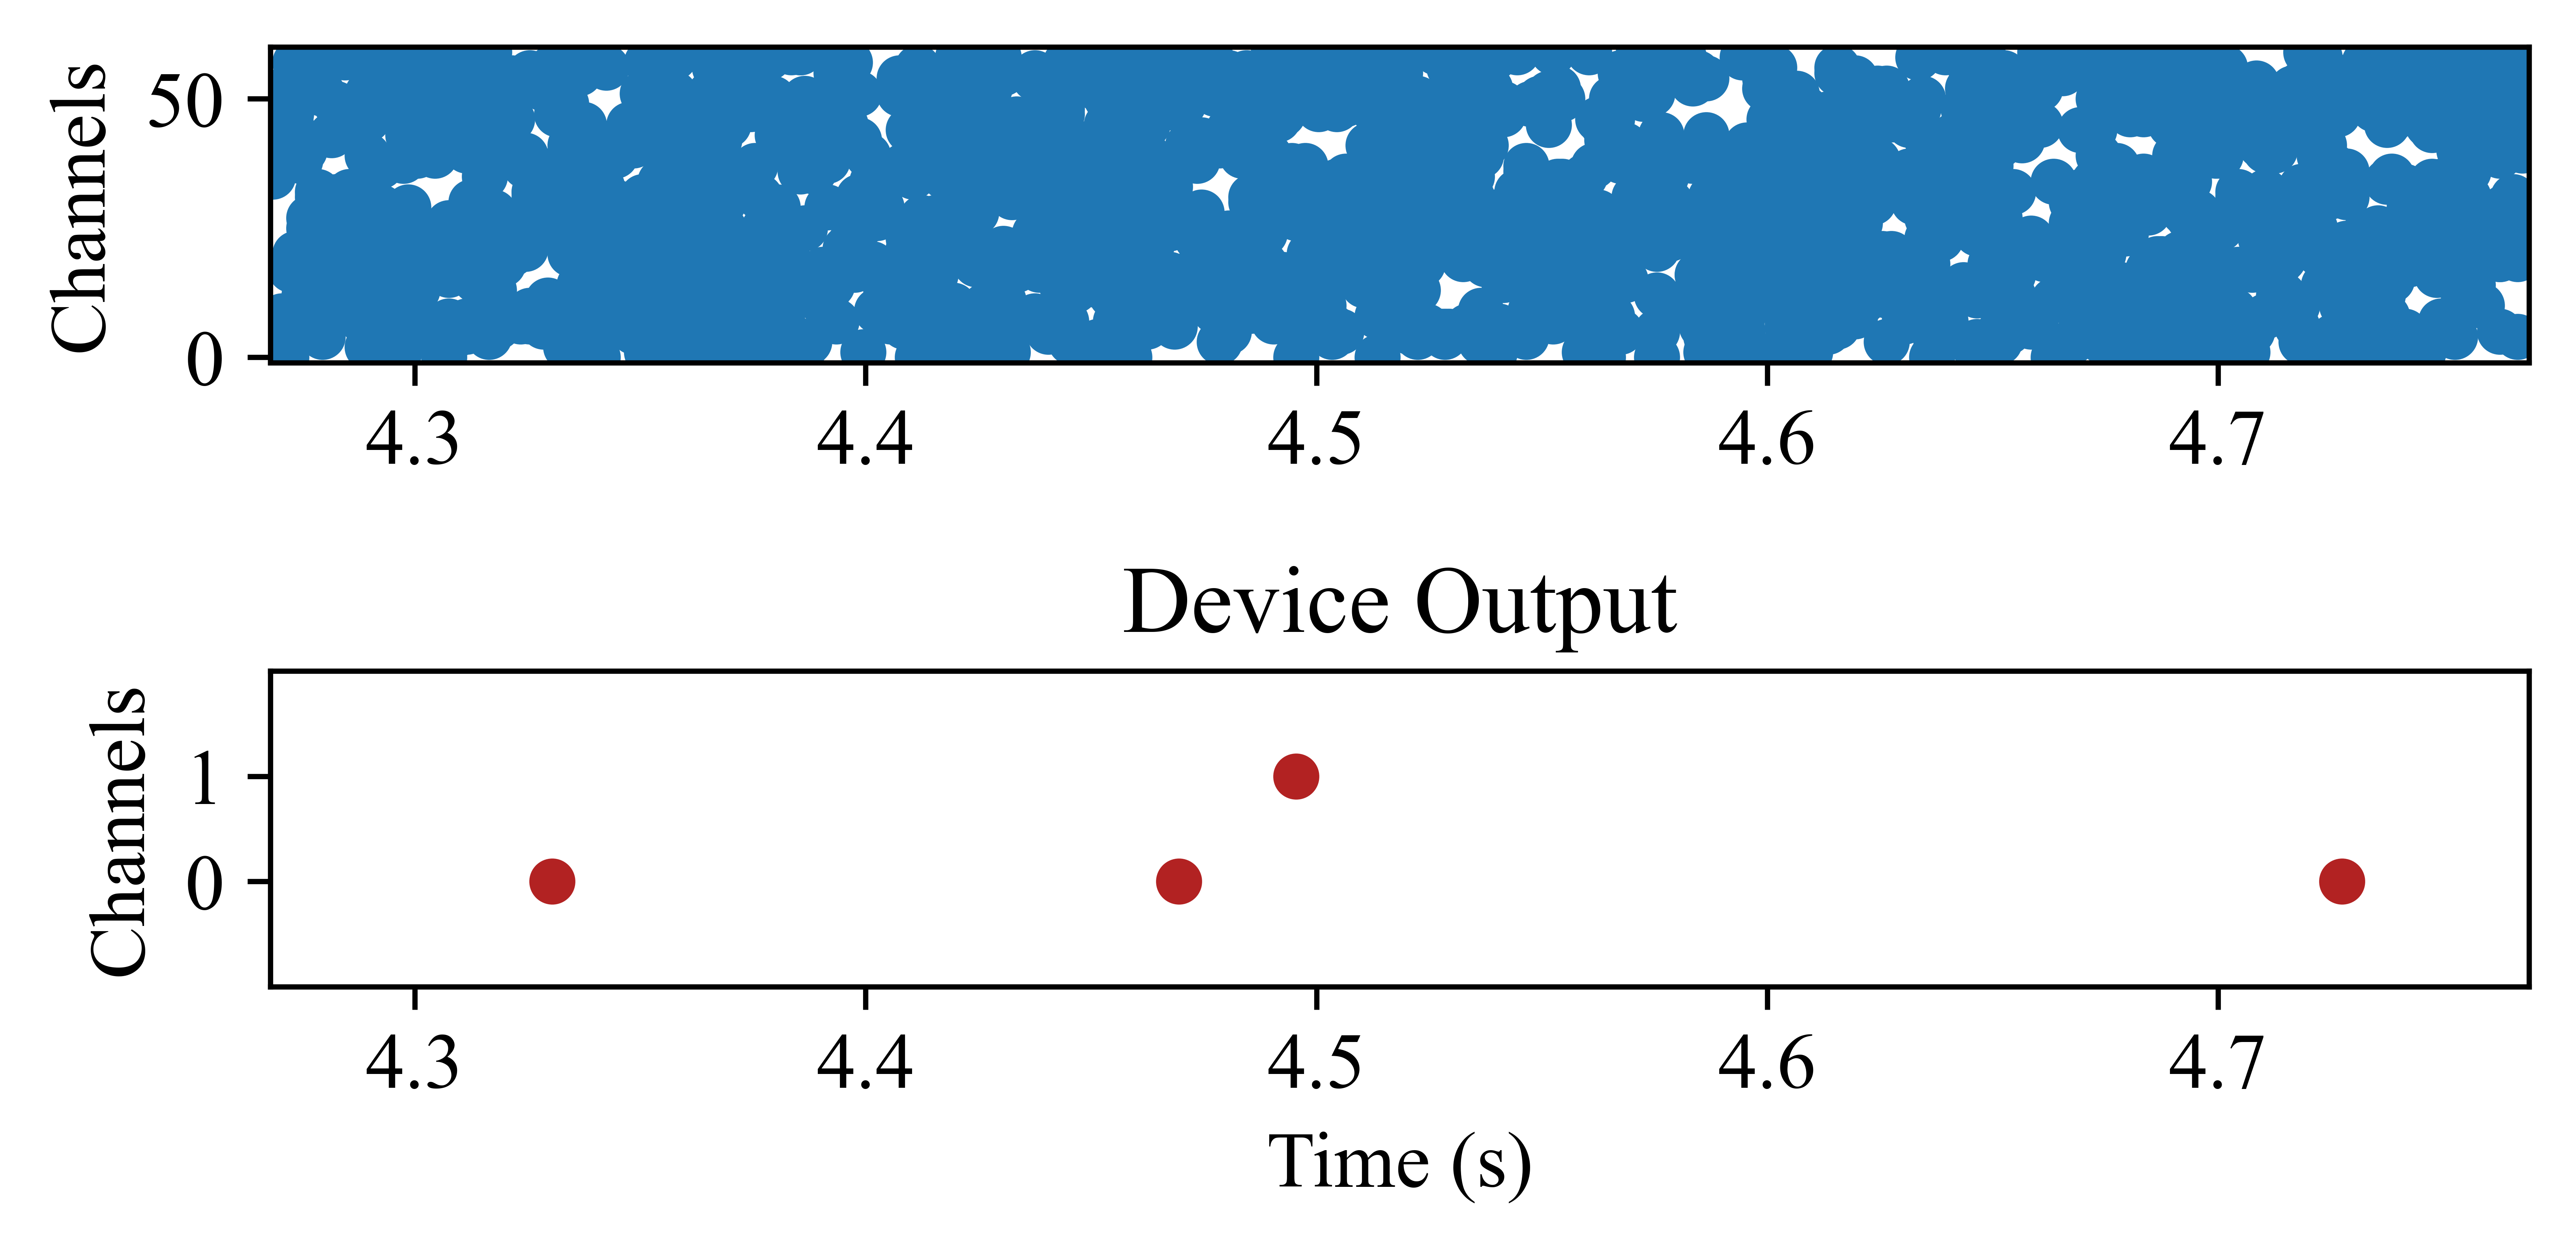

In [22]:
test_network(se2, spec, test_data[0])

Rate = 3.0


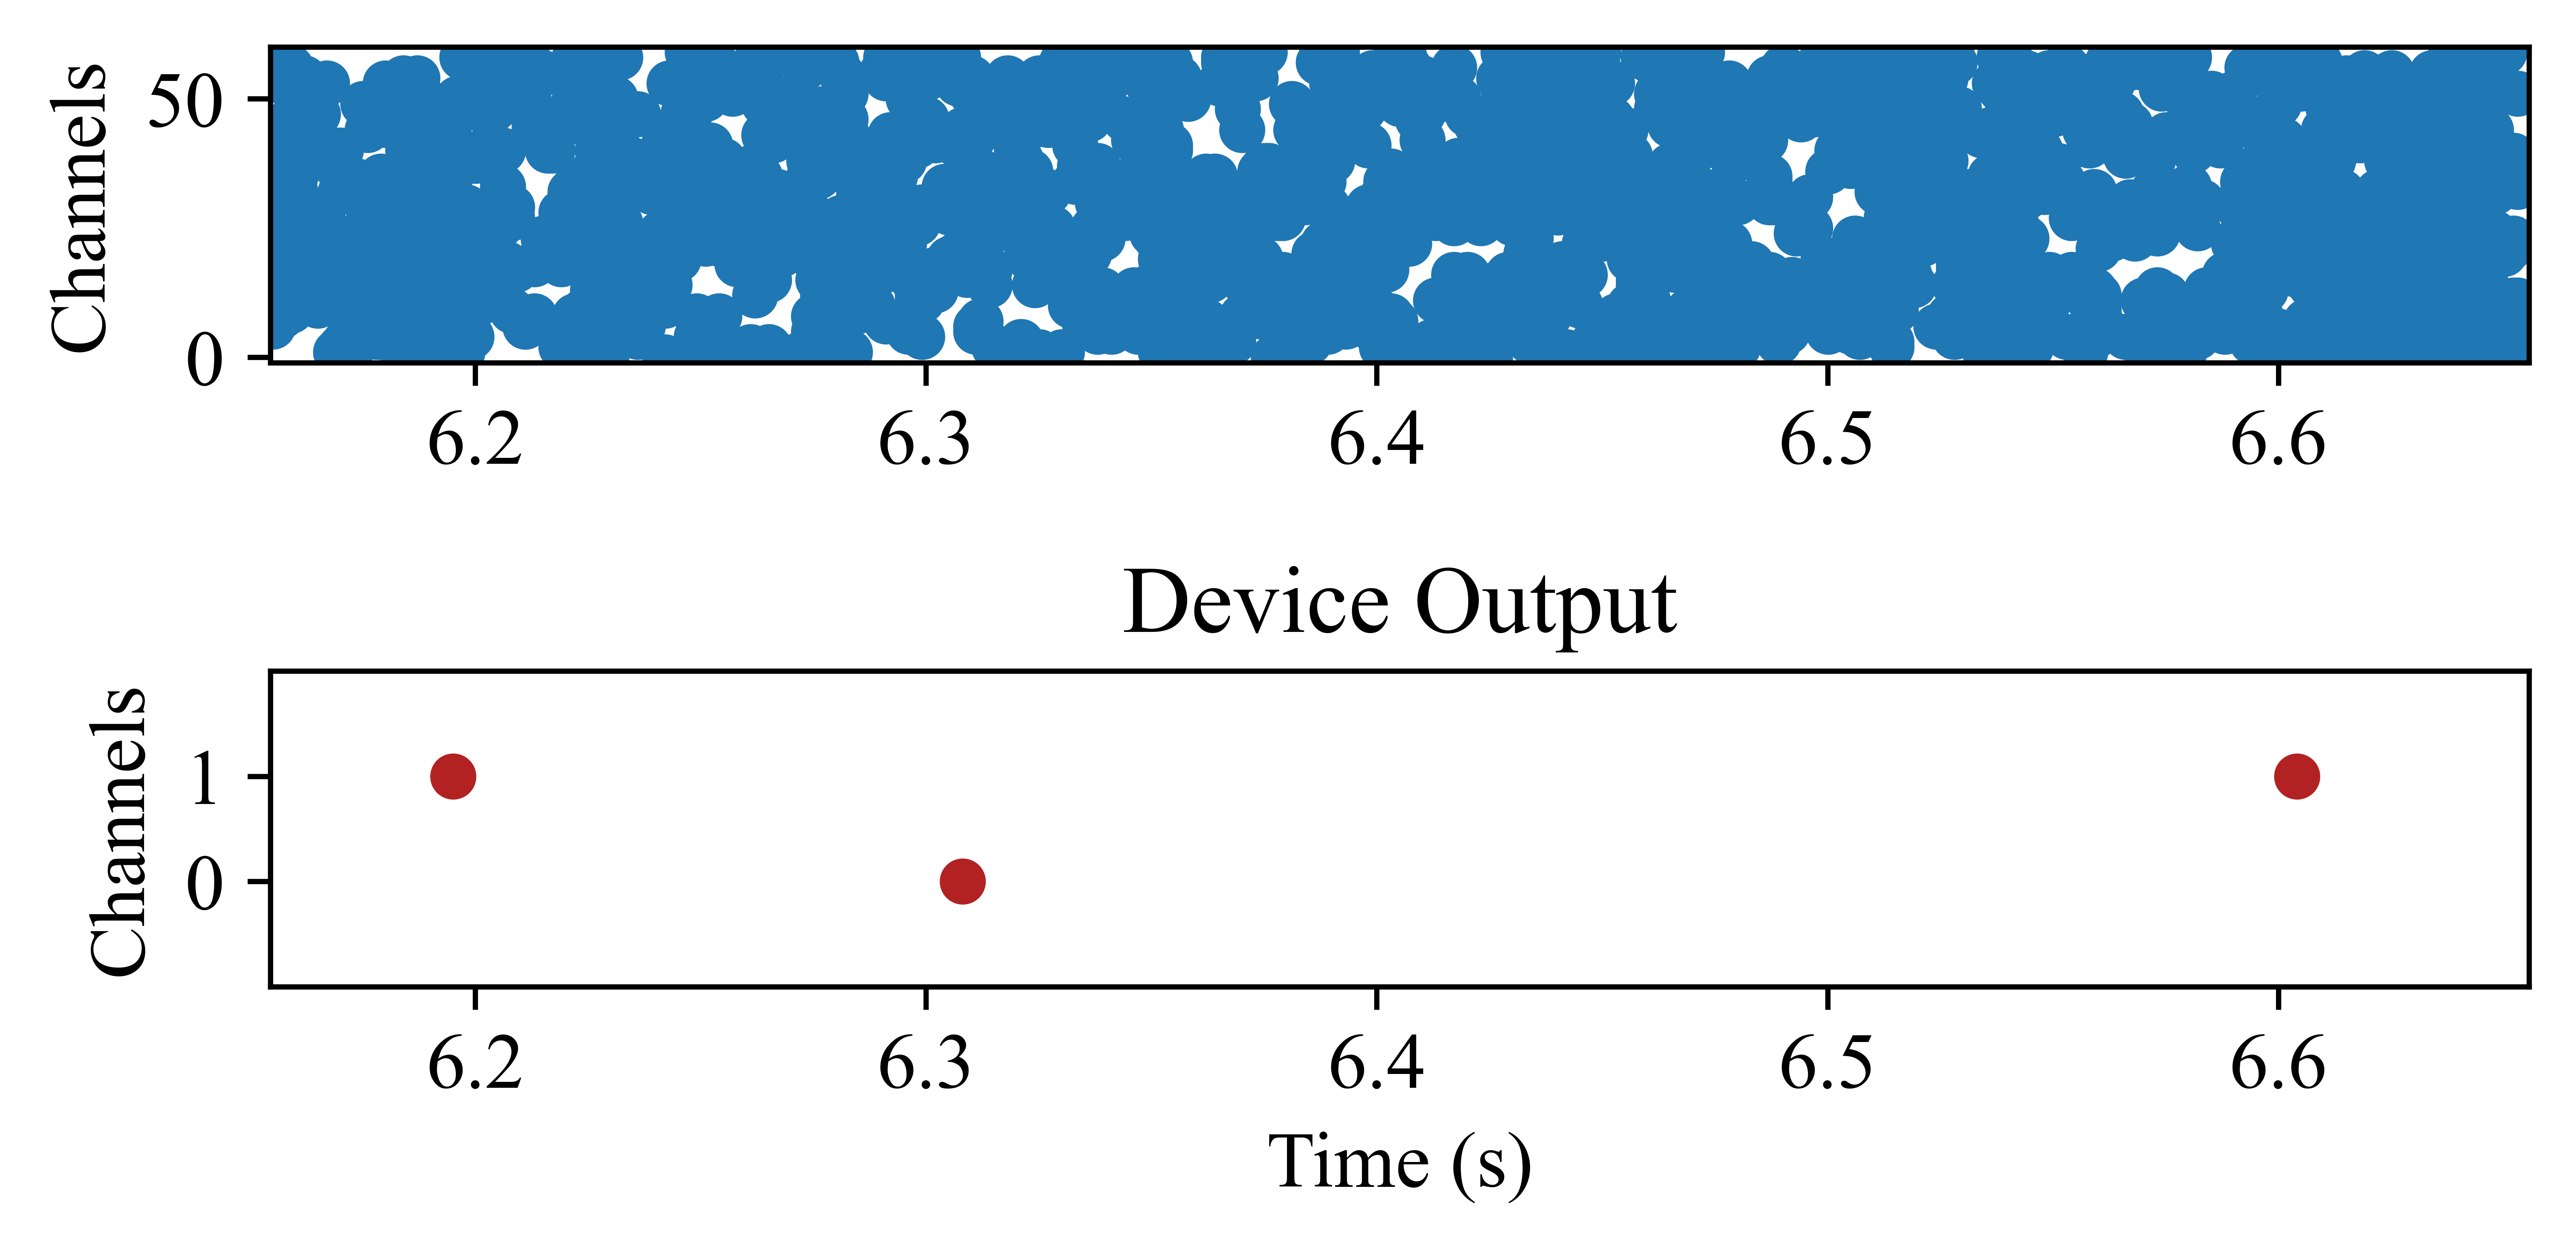

In [23]:
test_network(se2, spec, test_data[1])

Rate = 4.0


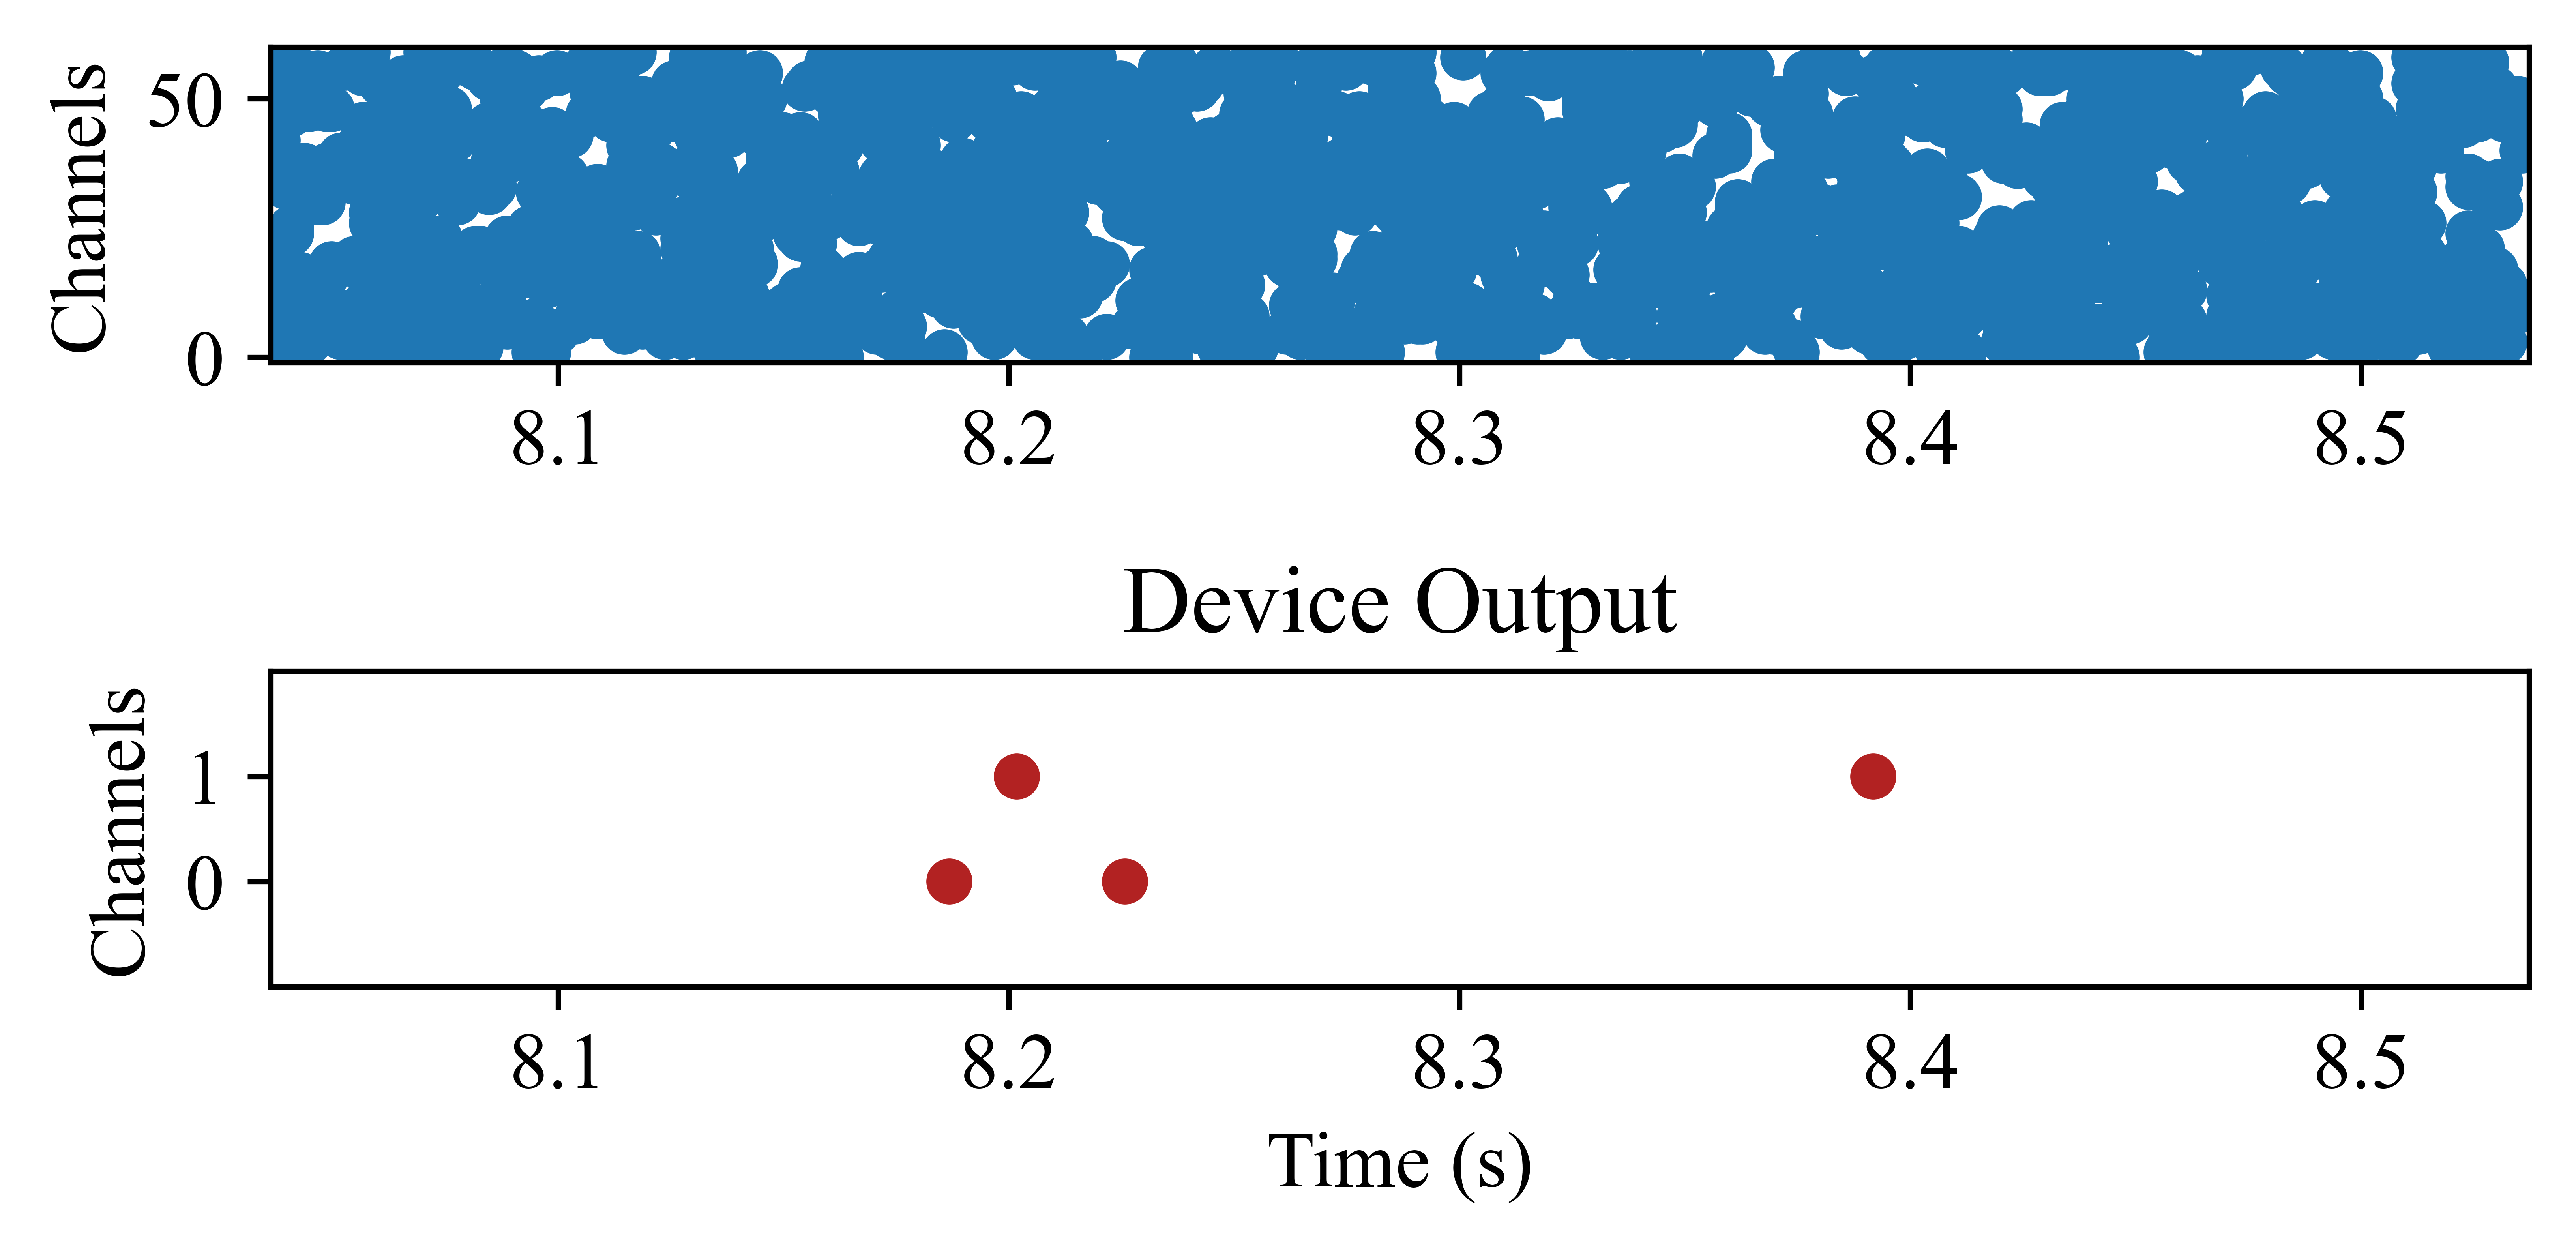

In [24]:
test_network(se2, spec, test_data[2])